In [1]:
include("../folder_path.jl")
import Pkg
Pkg.activate(project_folder)

  Activating project at `~/AAV2`


In [2]:
Pkg.status()

Status `~/AAV2/Project.toml`
  [fbb218c0] BSON v0.3.7
  [576b2be1] BioSeqInt v0.1.1
  [cb6160d5] DensityPlot v0.1.0 `https://gitlab.com/matteo.deleonardis2/densityplot.git#master`
  [587475ba] Flux v0.14.6
  [033835bb] JLD2 v0.4.36
  [fc28dbd6] PhageTree v0.1.0 `/home/students/s301803/CODE/PhageTree.jl#master`
  [d330b81b] PyPlot v2.11.2
  [88034a9c] StringDistances v0.11.2
  [98cad3c8] ValueHistories v0.5.4
  [10745b16] Statistics v1.9.0


In [4]:
using JLD2, BSON, Flux, PhageTree, PyPlot, BioSeqInt, Statistics, DensityPlot, LinearAlgebra, StringDistances

In [61]:
include(project_folder*"analysis/utils.jl")

confusion_matrix (generic function with 1 method)

# Data

### experiments 1 and 2
### cnn data are filtered (<100 counts)

In [6]:
threshold_experiment1 = -1.4792505511322604

-1.4792505511322604

In [7]:
threshold_experiment2 = -0.1828115693971919

-0.1828115693971919

In [8]:
threshold_experiment3 = 1.2303188241388179

1.2303188241388179

In [9]:
sequences_experiment1, counts_experiment1, labels_experiment1 = 
    load_data_cnn("$(project_folder)my_data/data_experiment1.jld2", threshold_experiment1, "experiment1");

In [10]:
sequences_experiment2, counts_experiment2, labels_experiment2 = 
    load_data_cnn("$(project_folder)my_data/data_experiment2.jld2",threshold_experiment2, "experiment2");

In [11]:
plasmid_experiment1, virus_experiment1 = load_experiment_phagetree("$(project_folder)my_data/data_experiment1.jld2", "experiment1");

In [12]:
plasmid_experiment2, virus_experiment2 = load_experiment_phagetree("$(project_folder)my_data/data_experiment2.jld2", "experiment2");

In [13]:
data_experiments = Data(plasmid_experiment1, plasmid_experiment2);

In [14]:
sequences_experiment3, counts_experiment3, labels_experiment3 = 
    load_data_cnn("$(project_folder)my_data/data_experiment3.jld2", threshold_experiment3, "experiment3");

In [15]:
data_experiment3 = load_data_phagetree("$(project_folder)my_data/data_experiment3.jld2", "experiment3");

# log selectivity

In [16]:
θexperiment1_cnn = [log(counts_experiment1[m,2] / counts_experiment1[m,1]) for m in axes(counts_experiment1, 1)];

In [17]:
θexperiment2_cnn = [log(counts_experiment2[m,2] / counts_experiment2[m,1]) for m in axes(counts_experiment2, 1)];

In [18]:
θexperiment3_cnn = [log(counts_experiment3[m,2] / counts_experiment3[m,1]) for m in axes(counts_experiment3, 1)];

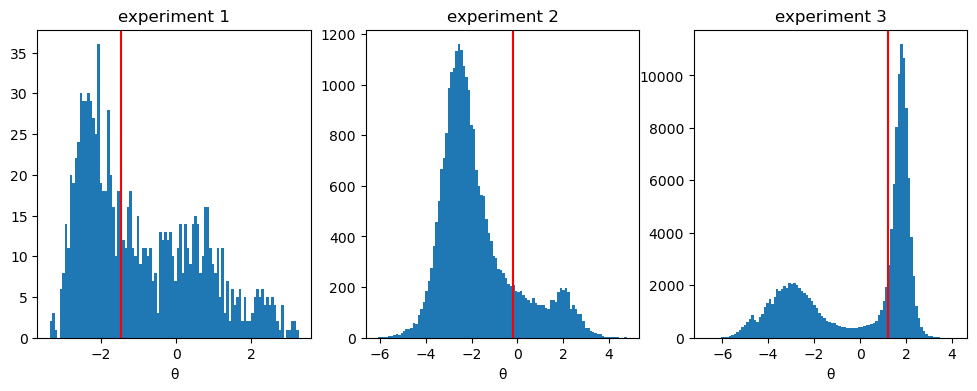

PyObject Text(0.5, 1.0, 'experiment 3')

In [19]:
fig, ax = subplots(1,3, figsize=(12,4))

ax[1].hist(filter(isfinite, θexperiment1_cnn), bins=100)
ax[1].axvline(threshold_experiment1, color="red")
ax[1].set_xlabel("θ")
ax[1].set_title("experiment 1")

ax[2].hist(filter(isfinite, θexperiment2_cnn), bins=100)
ax[2].axvline(threshold_experiment2, color="red")
ax[2].set_xlabel("θ")
ax[2].set_title("experiment 2")

ax[3].hist(filter(isfinite, θexperiment3_cnn), bins=100)
ax[3].axvline(threshold_experiment3, color="red")
ax[3].set_xlabel("θ")
ax[3].set_title("experiment 3")

# CNN

In [42]:
file_cnn = BSON.load(project_folder*"cnn_models/train_experiment2_thrfit.bson")
model_cnn = file_cnn[:model]
history_cnn = file_cnn[:history]

MVHistory{ValueHistories.History}
  :training_loss => 200 elements {Int64,Float32}

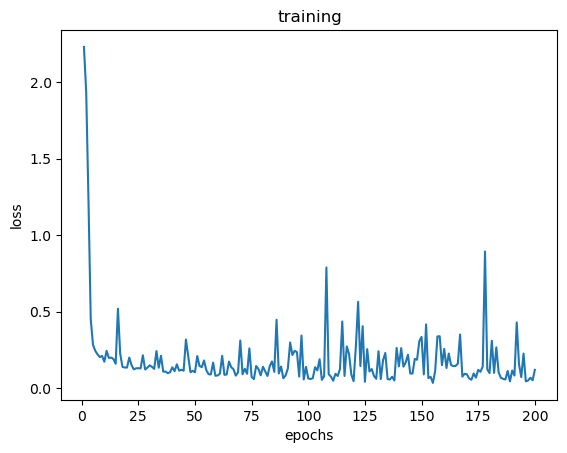

In [43]:
plot(get(history_cnn, :training_loss)...)
title("training")
xlabel("epochs")
ylabel("loss");

In [ ]:
logits_experiment1 = model_cnn(sequences_experiment1) |> x -> x[2,:] .- x[1,:];

In [ ]:
logits_experiment2 = model_cnn(sequences_experiment2) |> x -> x[2,:] .- x[1,:];

In [44]:
@load "logits_experiment3.jld2"

2-element Vector{Symbol}:
 :logits_experiment3
 :logits_experiment3_notfiltered

In [ ]:
logits_experiment3 = model_cnn(sequences_experiment3) |> x -> x[2,:] .- x[1,:];

In [ ]:
logits_experiment3_notfiltered = model_cnn(data_experiment3.sequences |> x->reshape(x, size(x,1), size(x,2), 1, size(x,3))) |> x -> x[2,:] .- x[1,:];

In [45]:
fig, ax = subplots(1,3, figsize=(12,4))

plot_density(θexperiment1_cnn, logits_experiment1, ax[1], filter=false)
ax[1].set_title("experiment 1 (training)")
ax[1].set_xlabel("θ")
ax[1].set_ylabel("logits");

plot_density(θexperiment2_cnn, logits_experiment2, ax[2], filter=true)
ax[2].set_title("experiment 2 (train), ρ=$(round(cor_sp(θexperiment2_cnn, logits_experiment2), digits=2))")
ax[2].set_xlabel("θ")
ax[2].set_ylabel("logits");

plot_density(θexperiment3_cnn, logits_experiment3, ax[3], filter=true)
ax[3].set_title("experiment 3 (test), ρ=$(round(cor_sp(θexperiment3_cnn, logits_experiment3), digits=2))")
ax[3].set_xlabel("θ")
ax[3].set_ylabel("logits");

LoadError: UndefVarError: logits_experiment1 not defined

In [ ]:
compute_accuracy(logits_experiment1, 0.0, θexperiment1_cnn, threshold_experiment1)

In [ ]:
compute_accuracy(logits_experiment2, 0.0, θexperiment2_cnn, threshold_experiment2)

In [ ]:
compute_accuracy(logits_experiment3, 0.0, θexperiment3_cnn, threshold_experiment3)

In [ ]:
compute_accuracy(logits_experiment3_notfiltered, 0.0, θexperiment3_pt, threshold_experiment3)

In [46]:
tp_cnn, fp_cnn = roc(logits_experiment3, θexperiment3_cnn, threshold_experiment3);

In [47]:
auc_val_cnn = auc(fp_cnn, tp_cnn) |> mean

0.8374523213960289

In [ ]:
plot(fp_cnn, tp_cnn)
title("ROC. Experiment 3 prediction. \n (Neural Network model)")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["AUC = $(round(auc_val_cnn, digits=2))"])

In [ ]:
confusion_matrix(logits_experiment3, 0.0, θexperiment3_cnn, threshold_experiment3) 

# PhageTree

In [20]:
file_phagetree = BSON.load(project_folder*"phagetree_models/train_experiment2_b256.bson")
model_pt = file_phagetree[:model]
history_pt = file_phagetree[:history]

MVHistory{ValueHistories.History}
  :loglikelihood_batch => 22000 elements {Int64,Float64}
  :loglikelihood => 200 elements {Int64,Float64}
  :epoch => 22000 elements {Int64,Int64}

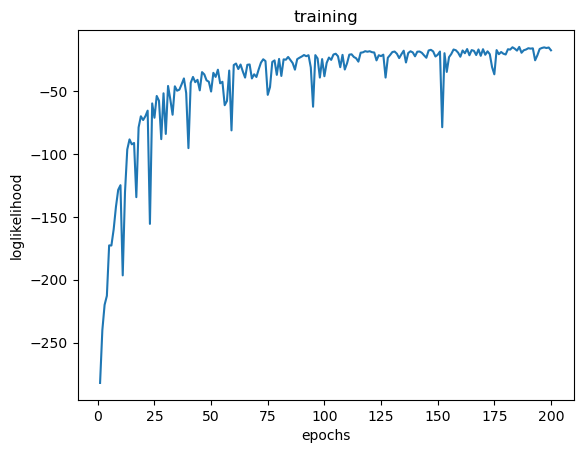

In [21]:
plot(get(history_pt, :loglikelihood)...)
title("training")
xlabel("epochs")
ylabel("loglikelihood");

In [22]:
@load "logselectivities_exp3.jld2"

1-element Vector{Symbol}:
 :ls_experiment3

In [23]:
ls_experiments = vec(log_selectivities(model_pt, data_experiments));

In [ ]:
ls_experiment3 = vec(log_selectivities(model_pt, data_experiment3)[:, 2]);

In [24]:
ls_experiment3_filtered = ls_experiment3[data_experiment3.counts[:, 1].>=100];

In [25]:
θexperiments_pt = vec(log_selectivities(data_experiments));

In [ ]:
θexperiment3_pt = vec(log_selectivities(data_experiment3));

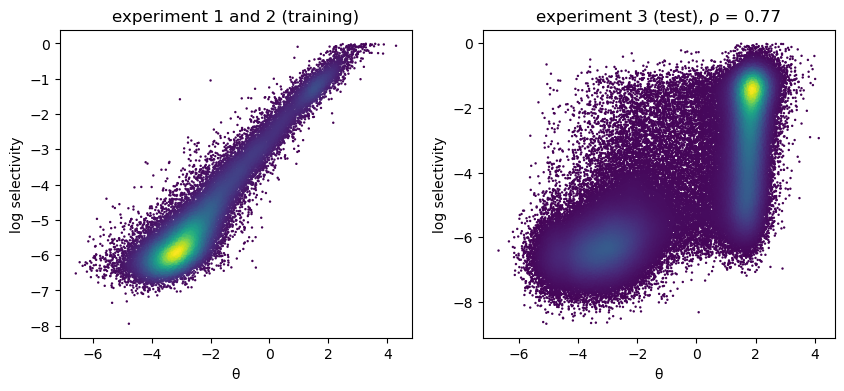

PyObject Text(446.72727272727263, 0.5, 'log selectivity')

In [26]:
fig, ax = subplots(1,2, figsize=(10,4))

plot_density(θexperiments_pt, ls_experiments, ax[1], filter=true)
ax[1].set_title("experiment 1 and 2 (training)")
ax[1].set_xlabel("θ")
ax[1].set_ylabel("log selectivity")

plot_density(θexperiment3_cnn, ls_experiment3_filtered, ax[2], filter=true)
ax[2].set_title("experiment 3 (test), ρ = $(round(cor_sp(θexperiment3_cnn, ls_experiment3_filtered), digits=2))")
ax[2].set_xlabel("θ")
ax[2].set_ylabel("log selectivity")

In [29]:
true_pos_rate, false_pos_rate = roc(ls_experiment3_filtered, θexperiment3_cnn, threshold_experiment3);

In [40]:
auc_val = auc(false_pos_rate, true_pos_rate) |> mean

0.9035601910117735

In [ ]:
plot(false_pos_rate, true_pos_rate)
title("ROC. Experiment 3 prediction.")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["AUC = $(round(auc_val, digits=2))"])

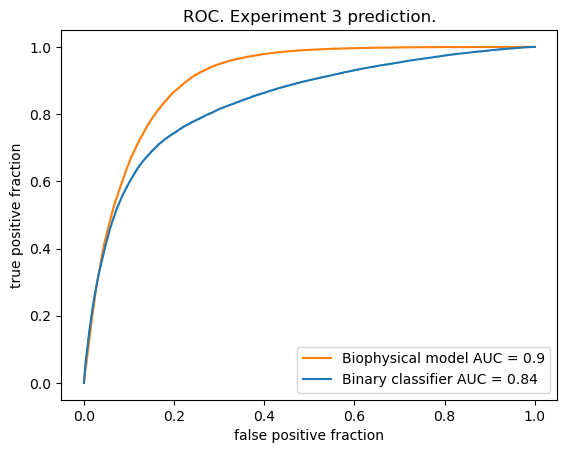

PyObject <matplotlib.legend.Legend object at 0x7ff62f9d8ee0>

In [48]:
plot(false_pos_rate, true_pos_rate, color="#ff7f0e")
plot(fp_cnn, tp_cnn, color="#1f77b4")
title("ROC. Experiment 3 prediction.")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["Biophysical model AUC = $(round(auc_val, digits=2))", "Binary classifier AUC = $(round(auc_val_cnn, digits=2))"])

In [30]:
ls_threshold = optimal_threshold(ls_experiment3_filtered, true_pos_rate, false_pos_rate)

-4.774115377733081

In [36]:
sequences_int_exp3 = onehot2string(sequences_experiment3, channel=true, padding=true)

140634-element Vector{Vector{Int64}}:
 [4, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [1, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [6, 1, 17, 12, 17, 1, 4, 8, 1, 17  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [1, 17, 4, 2, 19, 6, 8, 18, 1, 17  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [1, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 3, 1, 4, 8, 16, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 18, 4, 15, 4, 4, 8, 19, 15, 12  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 20, 4, 17, 4, 4, 8, 1, 2, 17  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 16, 18, 4, 4, 8, 11, 15, 17, 17  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 14, 4, 8, 2, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 

In [38]:
sequences_int_exp12 = onehot2string(data_experiments.sequences, channel=false, padding=true)

27970-element Vector{Vector{Int64}}:
 [3, 4, 4, 10, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 20, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 17, 17, 10, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 11, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [3, 4, 4, 4, 8, 15, 17, 17, 12, 13  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
 [

In [39]:
@save "logos/data_for_logos.jld2" sequences_int_exp12 sequences_int_exp3 ls_experiment3_filtered ls_threshold θexperiment3_cnn threshold_experiment3

In [ ]:
compute_accuracy(ls_experiment3_filtered, ls_threshold, θexperiment3_cnn, threshold_experiment3 )

In [ ]:
confusion_matrix(ls_experiment3_filtered, ls_threshold, θexperiment3_cnn, threshold_experiment3)

In [ ]:
plot_density(θexperiment3_cnn, ls_experiment3_filtered, filter=true)
title("Experiment 3 prediction")
xlabel("experimental log-selectivity")
ylabel("inferred log-probability viable state")
legend(["ρ = $(round(cor_sp(θexperiment3_cnn, ls_experiment3_filtered), digits=2))"])

# Distance analysis

In [49]:
file_exp1 = load("$(project_folder)my_data/data_experiment1.jld2")

Dict{String, Any} with 3 entries:
  "wt_aa"                 => "DEEEIRTTNPVATEQYGSVSTNLQRGNR"
  "sequences_experiment1" => ["DEELIRTTNPVATEQYGSVSTNLQRGNR", "DEEEIYTTNPVATEQY…
  "counts_experiment1"    => [1439 349; 2829 3326; … ; 2053 6849; 4249 409]

In [50]:
wt_aa = file_exp1["wt_aa"]

"DEEEIRTTNPVATEQYGSVSTNLQRGNR"

In [59]:
String(int2aa.([1,2,3]))

"ACD"

In [62]:
sequences_string_experiment3_cnn = onehot2string(sequences_experiment3, channel=true, padding=false);

In [65]:
distances_cnn = map(x->evaluate(Levenshtein(), x, wt_aa), sequences_string_experiment3_cnn);

In [66]:
dmin, dmax = extrema(distances_cnn)

(3, 29)

In [67]:
@views ls_experiment3_cnn = log_selectivities(model_pt, sequences_experiment3[:,:,1,:])[:,2];

In [68]:
ls_experiment3_cnn == ls_experiment3_filtered

true

In [69]:
accuracy_distance = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 100
        accuracy_distance[i] = NaN
        continue
    end
    accuracy_distance[i] = compute_accuracy(logits_experiment3[idx], 0.0, θexperiment3_cnn[idx], threshold_experiment3)
end

In [70]:
accuracy_distance_energy = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 100
        accuracy_distance_energy[i] = NaN
        continue
    end
    accuracy_distance_energy[i] = compute_accuracy(ls_experiment3_cnn[idx], ls_threshold, θexperiment3_cnn[idx], threshold_experiment3)
end

In [71]:
pearson_distance = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 100
        pearson_distance[i] = NaN
        continue
    end
    pearson_distance[i] = cor_sp(θexperiment3_cnn[idx], ls_experiment3_cnn[idx])
end

In [72]:
viable_frac = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 100
        viable_frac[i] = NaN
        continue
    end
    viable_frac[i] = sum(θexperiment3_cnn[idx] .>= threshold_experiment3)/length(idx)
end

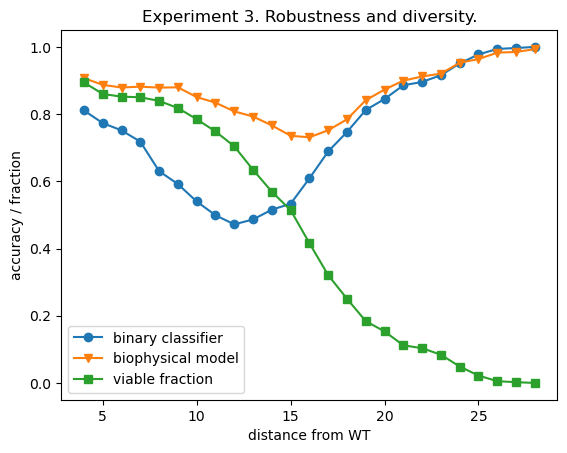

PyObject Text(0.5, 1.0, 'Experiment 3. Robustness and diversity.')

In [75]:
plot(dmin:dmax, accuracy_distance, marker="o", color="#1f77b4")
plot(dmin:dmax, accuracy_distance_energy, marker="v", color="#ff7f0e")
plot(dmin:dmax, viable_frac, marker="s", color="#2ca02c")
legend(["binary classifier", "biophysical model", "viable fraction"])
ylabel("accuracy / fraction")
xlabel("distance from WT")
title("Experiment 3. Robustness and diversity.")

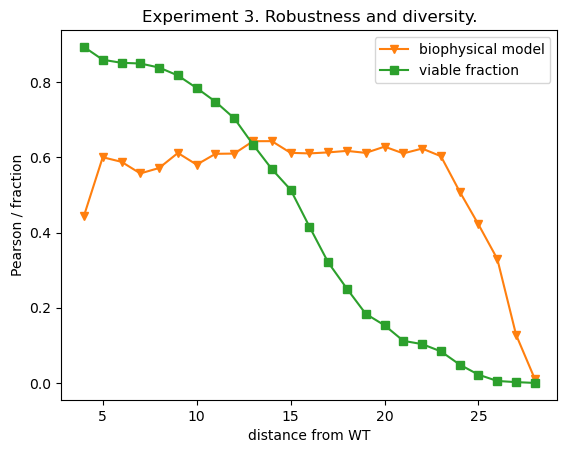

PyObject Text(0.5, 1.0, 'Experiment 3. Robustness and diversity.')

In [76]:
plot(dmin:dmax, pearson_distance, marker="v", color="#ff7f0e")
plot(dmin:dmax, viable_frac, marker="s", color="#2ca02c")
legend(["biophysical model", "viable fraction"])
ylabel("Pearson / fraction")
xlabel("distance from WT")
title("Experiment 3. Robustness and diversity.")

In [ ]:
idx=findall(distances_pt.==12)
plot_density(θexperiment3_pt[idx], ls_experiment3[idx], filter=true)